# Bonus Task: Machine Learning

We need to develop a machine learning model trained on the processsed dataset to detect which passengers were transported by the anomaly. We will predict on provided test.csv.

We have already cleaned_dataset.csv which is a cleaned dataset that we can use as the training dataset. 

We also need to clean test.csv, which we will clean in the same way we cleaned train taking values from train ONLY. (so we only clean test and don't like influence our outcomes based on 'knowing' the test dataset)

We will do this by creating a 'cleaning function', then we will reclean our original unclean dataset using that function making sure that we get a similar result as our cleaned_dataset, and then apply that cleaning function on test.csv

In [1]:
# import libraries here

import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import our required datasets

cleaned = pd.read_csv('../Task2/cleaned_dataset.csv')
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [3]:
# See info about uncleaned test 

test.info()

#We need to clean it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## Data Cleaning Step

- Make cleaning function that cleans based on cleaned dataset ONLY (dont clean test using test data)
- Test the cleaning function on train data to get cleanTrain and on test to get cleanTest
- Then we will use cleanTrain and cleanTest for machine learning

In [4]:
#Create our cleaning function (I will be looking in #AstroGoodBoy_notebook_cleaning for reference and getting the same code in)
np.random.seed(69)

def clean(data):
    cleanData = data.copy()

    #PassengerId + Name column stuff
    cleanData['GroupId'] = data['PassengerId'].str[:4]
    cleanData['GroupSize'] = data.groupby(data['PassengerId'].str[:4]).transform('size')

    #HomePlanet and Destination stuff
    cleanData['HomePlanet'] = cleanData.groupby(cleanData['GroupId'])['HomePlanet'].transform('first')
    cleanData['HomePlanet'] = cleanData['HomePlanet'].fillna('Earth')
    cleanData['Destination'] = cleanData['Destination'].fillna('TRAPPIST-1e')

    #Cabin stuff
    cleanData[['Cabin P1', 'Cabin P2', 'Cabin P3']] = cleanData['Cabin'].str.split("/", expand = True)
    cleanData['Cabin P2'] = cleanData['Cabin P2'].astype('Int64')
    cleanData['Cabin P1'] = cleanData['Cabin P1'].replace('T', 'F')
    cleanData['Cabin P1'] = cleanData['Cabin P1'].fillna('F')

    #We needed a randomfill function to do a bunch of our work
    #We need to somehow make sure we get random values from train.csv and put in test.csv (we not allowed to access test.csv values)
    #Instead to solve this issue, we will change our randomFill code to always take values from our already CLEANED dataset!
    def randomFill(column, annoyingcase = False):
      SGMRW = column.copy()
      indices = SGMRW[SGMRW.isna()].index
      if annoyingcase == False:
       randomVals = np.random.choice(cleaned[column.name], size = SGMRW.isna().sum(), replace = True)
      #Annoying subcase introduced that we dealt with ughh
      else:
       randomVals = np.random.choice(cleaned[cleaned['Cabin P1'] == column.name]['Cabin P2'], size = SGMRW.isna().sum(), replace = True)
      SGMRW.loc[indices] = randomVals
      return SGMRW

    #More cabin stuff
    cleanData['Cabin P2'] = cleanData.groupby(cleanData['Cabin P1'])['Cabin P2'].transform(lambda x: randomFill(x, True))
    cleanData['Cabin P3'] = cleanData.groupby(cleanData['GroupId'])['Cabin P3'].transform('first')
    cleanData['Cabin P3'] = randomFill(cleanData['Cabin P3'])
    cleanData['Cabin'] = cleanData['Cabin P1'].astype(str) + '/' + cleanData['Cabin P2'].astype(str) + '/' + cleanData['Cabin P3'].astype(str)

    #Cryosleep, VIP and some spendings stuff
    cleanData['VIP'] = (cleanData['VIP']).astype(bool)
    cleanData['VIP'] = cleanData['VIP'].fillna(False)
    #lmao this part looking very inefficient now but whatever 
    tempData = cleanData.copy()
    tempData['RoomService'] = tempData['RoomService'].fillna(0.0)
    tempData['FoodCourt'] = tempData['FoodCourt'].fillna(0.0)
    tempData['ShoppingMall'] = tempData['ShoppingMall'].fillna(0.0)
    tempData['Spa'] = tempData['Spa'].fillna(0.0)
    tempData['VRDeck'] = tempData['VRDeck'].fillna(0.0)
    indices = cleanData[(cleanData['CryoSleep'].isna() == True) & ((cleanData['RoomService'] + cleanData['FoodCourt'] + cleanData['ShoppingMall'] + cleanData['Spa'] + cleanData['VRDeck']) != 0) & ((tempData['RoomService'] + tempData['FoodCourt'] + tempData['ShoppingMall'] + tempData['Spa'] + tempData['VRDeck']) == 0)].index
    cleanData.loc[indices, 'CryoSleep'] = True
    cleanData.loc[indices, 'RoomService':'VRDeck'] = 0.0
    indices = cleanData[(cleanData['CryoSleep'].isna() == True) & ((cleanData['RoomService'] + cleanData['FoodCourt'] + cleanData['ShoppingMall'] + cleanData['Spa'] + cleanData['VRDeck']) == 0)].index
    cleanData.loc[indices, 'CryoSleep'] = True
    cleanData['CryoSleep'] = (cleanData['CryoSleep']).astype(bool)
    cleanData['CryoSleep'] = cleanData['CryoSleep'].fillna(False)
    cleanData.loc[cleanData['CryoSleep'] == True, 'RoomService':'VRDeck'] = 0

    #Age and spendings stuff
    spendings = cleanData[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).sum(axis = 1)
    indices = cleanData[((spendings == 0) & (cleanData['CryoSleep'] == False) & (cleanData['Age'].isna() == True))].index
    randomVals = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], size = len(cleanData[((spendings == 0) & (cleanData['CryoSleep'] == False) & (cleanData['Age'].isna() == True))]), replace = True)
    cleanData.loc[indices, 'Age'] = randomVals
    cleanData['Age'] = randomFill(cleanData['Age'])
    cleanData['RoomService'] = randomFill(cleanData['RoomService'])
    cleanData['FoodCourt'] = randomFill(cleanData['FoodCourt'])
    cleanData['ShoppingMall'] = randomFill(cleanData['ShoppingMall'])
    cleanData['Spa'] = randomFill(cleanData['Spa'])
    cleanData['VRDeck'] = randomFill(cleanData['VRDeck'])
    cleanData.loc[cleanData['Age'] < 13, 'RoomService':'VRDeck'] = 0

    #Final cleaning steps
    cleanData.drop(columns = ['Name', 'Cabin'] , inplace = True)
    cleanData['TotalSpendings'] = cleanData['RoomService'] + cleanData['FoodCourt'] + cleanData['ShoppingMall'] + cleanData['Spa'] + cleanData['VRDeck']
    
    return cleanData

Crazy that so much of our time spent on the other notebook and so much of our code there can be compressed to just this

In [5]:
#Examine the expected final cleaned product
cleaned

,PassengerId,GroupId,GroupSize,Transported,HomePlanet,Destination,CryoSleep,Cabin P1,Cabin P2,Cabin P3,Age,VIP,TotalSpendings,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0001_01,1,1,False,Europa,TRAPPIST-1e,False,B,0,P,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,2,1,True,Earth,TRAPPIST-1e,False,F,0,S,24.0,False,736.0,109.0,9.0,25.0,549.0,44.0
2,0003_01,3,2,False,Europa,TRAPPIST-1e,False,A,0,S,58.0,True,10383.0,43.0,3576.0,0.0,6715.0,49.0
3,0003_02,3,2,False,Europa,TRAPPIST-1e,False,A,0,S,33.0,False,5176.0,0.0,1283.0,371.0,3329.0,193.0
4,0004_01,4,1,True,Earth,TRAPPIST-1e,False,F,1,S,16.0,False,1091.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,9276,1,False,Europa,55 Cancri e,False,A,98,P,41.0,True,8536.0,0.0,6819.0,0.0,1643.0,74.0
8689,9278_01,9278,1,False,Earth,PSO J318.5-22,True,G,1499,S,18.0,False,0.0,0.0,0.0,0.0,0.0,0.0
8690,9279_01,9279,1,True,Earth,TRAPPIST-1e,False,G,1500,S,26.0,False,1873.0,0.0,0.0,1872.0,1.0,0.0
8691,9280_01,9280,2,False,Europa,55 Cancri e,False,E,608,S,32.0,False,4637.0,0.0,1049.0,0.0,353.0,3235.0


In [6]:
#Clean train and see if it looks similar

cleanTrain = clean(train)
cleanTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     8693 non-null   object 
 1   HomePlanet      8693 non-null   object 
 2   CryoSleep       8693 non-null   bool   
 3   Destination     8693 non-null   object 
 4   Age             8693 non-null   float64
 5   VIP             8693 non-null   bool   
 6   RoomService     8693 non-null   float64
 7   FoodCourt       8693 non-null   float64
 8   ShoppingMall    8693 non-null   float64
 9   Spa             8693 non-null   float64
 10  VRDeck          8693 non-null   float64
 11  Transported     8693 non-null   bool   
 12  GroupId         8693 non-null   object 
 13  GroupSize       8693 non-null   int64  
 14  Cabin P1        8693 non-null   object 
 15  Cabin P2        8693 non-null   Int64  
 16  Cabin P3        8693 non-null   object 
 17  TotalSpendings  8693 non-null   f

In [7]:
#Check if cleaning done properly
cleanTrain[(cleanTrain['Age'] < 13) & (cleanTrain['TotalSpendings'] > 0)]
#Hmm looks good

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupSize,Cabin P1,Cabin P2,Cabin P3,TotalSpendings


In [8]:
#Okkk lets clean our test now 

cleanTest = clean(test)
cleanTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     4277 non-null   object 
 1   HomePlanet      4277 non-null   object 
 2   CryoSleep       4277 non-null   bool   
 3   Destination     4277 non-null   object 
 4   Age             4277 non-null   float64
 5   VIP             4277 non-null   bool   
 6   RoomService     4277 non-null   float64
 7   FoodCourt       4277 non-null   float64
 8   ShoppingMall    4277 non-null   float64
 9   Spa             4277 non-null   float64
 10  VRDeck          4277 non-null   float64
 11  GroupId         4277 non-null   object 
 12  GroupSize       4277 non-null   int64  
 13  Cabin P1        4277 non-null   object 
 14  Cabin P2        4277 non-null   Int64  
 15  Cabin P3        4277 non-null   object 
 16  TotalSpendings  4277 non-null   float64
dtypes: Int64(1), bool(2), float64(7),

In [9]:
#Great, now our cleanTest has been cleaned in the same way as our cleanTrain has been cleaned
cleanTest

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupSize,Cabin P1,Cabin P2,Cabin P3,TotalSpendings
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,0013,1,G,3,S,0.0
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,0018,1,F,4,S,2832.0
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,0019,1,C,0,S,0.0
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,0021,1,C,1,S,7418.0
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,0023,1,F,5,S,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,9266,2,G,1496,S,0.0
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,9269,1,F,629,P,1018.0
4274,9271_01,Mars,True,55 Cancri e,1.0,False,0.0,0.0,0.0,0.0,0.0,9271,1,D,296,P,0.0
4275,9273_01,Europa,False,TRAPPIST-1e,32.0,False,0.0,2680.0,0.0,0.0,523.0,9273,1,D,297,P,3203.0


## Machine Learning Step

The metric we will be trying to maximize is the f1_score = 2 * precision * recall/precision + recall

The different classifiers we will try out to get the best model is 
1) Logisitic Regression
2) SVC (Support Vector Classifier)
3) DecisionTreeClassifier
4) RandomForestClassifier
5) GradientBoostingClassifier 
6) KNeighborsClassifier
7) GaussianNB (Naive Bayes) Classifier
8) LinearSVC

### Data Preprocessing 

The data preprocessing we will do here is what what we need to do in general for all models

yes theres still more left, we finished data cleaning, which was technically the first step to this.

So heres what we need to do with respect to data preprocessing:
- Remove passengerId and groupId (since it acts more like an index than as datapoints so we dont want our model to consider that)
- Convert our text columns into something the models can work with (Binary matrix) (one hot encoding)
- Split out train and test into X and Y. X is what we will train on (all the data), and Y is what we need to predict ('transported')

In [10]:
#Removing passengerId and groupId

cleanTrain.drop(columns = ['PassengerId', 'GroupId'], inplace = True)
cleanTest.drop(columns = ['PassengerId', 'GroupId'], inplace = True)

In [11]:
#Splitting into xtrain ytrain allat

xtrain = cleanTrain.drop(columns = 'Transported')
ytrain = cleanTrain['Transported']
ytrain = ytrain.astype(int)
xtest = cleanTest.copy()

In [12]:
#One Hot Encoding

#Create preprocessor to do the main preprocessing
catCols = ['HomePlanet', 'Destination', 'Cabin P1', 'Cabin P3']
enc = OneHotEncoder(handle_unknown = 'ignore')
preprocessor = ColumnTransformer(transformers = [('Categorical', enc, catCols)], remainder = 'passthrough')

#use it on our train and test data
xtrain = preprocessor.fit_transform(xtrain)
#Don't fit to the test and use our already fitted preprocessor to avoid data leakage
xtest = preprocessor.transform(xtest)


Now we are completely done with data preprocessing, let us start with the machine learning

### Logistic Regression

In [13]:
#Let's make our pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(solver='liblinear', random_state = 69))])

#Parameters we will test with gridsearchcv
paramGrid = {'scaler' : [StandardScaler(), QuantileTransformer(), MinMaxScaler(), 'passthrough'], 'model__C' : [0.1, 1.0, 10]}

#Perform GridSearchCV on our training data with cv = 10 (10 fold cross validation)
gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")
#We will just extend this same logic to other models as well

Best F1 Score: 0.7903464042177677
Best Parameters: {'model__C': 0.1, 'scaler': 'passthrough'}


In [14]:
#To store our results

results = []
results.append({'model': 'Logistic Regression', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

With logistic regression, and these parameters, the best f1 score we got was around 0.79, with c = 0.1 and using no scaler interestingly


### SVC (Support Vector Classifier)

In [15]:
#Making our pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('model', SVC(kernel='rbf', random_state=69))])

#Removing linear from here and adding LinearSVM instead (bro this taking so long to run)
#Tested a lot with cv = 5 (and found out a lot about suitable params), but for final output, let's test with cv = 10 only
paramGrid = {'scaler' : [StandardScaler(), 'passthrough'], 'model__C': [1.0, 1.5]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'SVC', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.8008337033079844
Best Parameters: {'model__C': 1.0, 'scaler': 'passthrough'}


With SVM, we get the best f1 score of 0.8! with c = 1 and no scaler.

### Linear SVC

In [16]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearSVC(random_state = 69, max_iter = 5000))])

paramGrid = {'scaler' : [StandardScaler(), QuantileTransformer(), MinMaxScaler()], 'model__C': [0.01, 0.1, 1.0, 10.0]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'Linear SVC', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.7864586703652299
Best Parameters: {'model__C': 1.0, 'scaler': StandardScaler()}


With LinearSVM, the best f1 score we got was around 0.78, with c = 1.0 and using StandardScaler()

### K Neighbors Classifier

In [17]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])

#KNeighbors wud be horrible with passthrough since it is distance dependent so we can skip testing passthrough
paramGrid = {'scaler' : [StandardScaler(), QuantileTransformer(), MinMaxScaler()], 'model__n_neighbors': [5, 10, 15]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'KNeighbors', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.7683505714259085
Best Parameters: {'model__n_neighbors': 15, 'scaler': StandardScaler()}


With KNeighbors Classifier, the best f1 score we got was around 0.76, 15 neighbors and StandardScaler()

### GaussianNB Classifier

In [18]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', GaussianNB())])

paramGrid = {'scaler' : [StandardScaler(), QuantileTransformer(output_distribution='normal'), MinMaxScaler(), 'passthrough'], 'model__var_smoothing' : [1e-9, 1e-8, 1e-7]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'GaussianNB', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.7742796128277358
Best Parameters: {'model__var_smoothing': 1e-09, 'scaler': StandardScaler()}


With GaussianNB Classifier, the best f1 score we got was around 0.77, with var smoothing at 1e-09, and StandardScaler()

### Decision Tree Classifier

In [19]:
#First of our tree based classifiers, this will not require scaling

pipe = Pipeline([('model', DecisionTreeClassifier(random_state = 69))])

paramGrid = {'model__max_depth' : [5, 10, 20, None], 'model__min_samples_leaf': [1, 5, 10]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'Decision Tree', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.7652345490143826
Best Parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 10}


With Decision Tree Classifier, the best f1 score we got was around 0.76 with max depth at 5 and min leaf samples as 10

### Random Forest Classifier

In [20]:
pipe = Pipeline([('model', RandomForestClassifier(random_state = 69))])

#Changing a few of these values on 2nd run to decrease overfitting
paramGrid = {'model__max_depth' : [5, 10, 15], 'model__min_samples_leaf': [5, 10, 15], 'model__n_estimators': [100, 200], 'model__max_features': ['sqrt', 1.0]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'Random Forest', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.7947527332977147
Best Parameters: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__n_estimators': 100}


With Random Forest Classifier, the best f1 score we got was around 0.79 with max depth at 10 and min leaf samples as 10 and 100 n estimators, with sqrt max features

### Gradient Boosting Classifier

In [21]:
pipe = Pipeline([('model', GradientBoostingClassifier(random_state = 69))])

#Changing params 2nd time to try to increase f1 score
paramGrid = {'model__max_depth' : [3, 5], 'model__min_samples_leaf': [10, 15, 20], 'model__learning_rate': [0.05, 0.1], 'model__n_estimators': [100, 200]}

gridSearch = GridSearchCV(estimator = pipe, param_grid = paramGrid, scoring = 'f1', cv = 10, n_jobs = -1)
gridSearch.fit(xtrain, ytrain)

print(f"Best F1 Score: {gridSearch.best_score_}")
print(f"Best Parameters: {gridSearch.best_params_}")

results.append({'model': 'Gradient Boosting', 'Best Score' : gridSearch.best_score_, 'Best Parameters' : gridSearch.best_params_})

Best F1 Score: 0.794774280977114
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_samples_leaf': 15, 'model__n_estimators': 100}


Gradient Boosting Classifier gets a best f1 score of around 0.79 with max depth 3, min leaf samples 15 and 100 n estimators.

### Picking Best Model

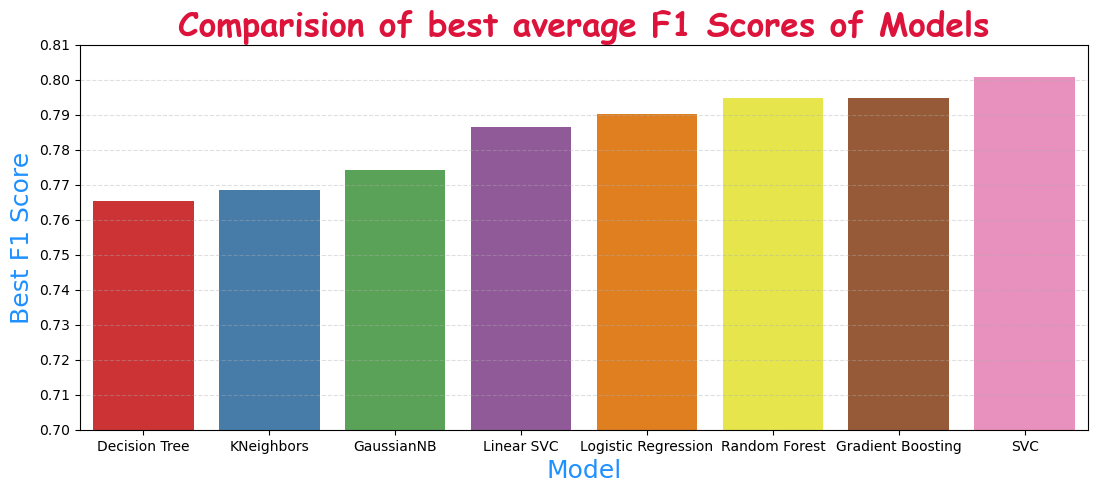

In [31]:
#Let's visualize our results of best averagee f1 scores acquired by our models

plt.figure(figsize = (13, 5), dpi = 100)

ax = sns.barplot(data = pd.DataFrame(results).sort_values(by = 'Best Score', ascending = True), x = 'model', y = 'Best Score', hue = 'model', legend = False, palette = 'Set1')
ax.set_ylim([0.7, 0.81])

plt.yticks(np.arange(0.7, 0.82, 0.01))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.4)

plt.ylabel('Best F1 Score', color = 'dodgerblue', size = 18)
plt.xlabel('Model', color = 'dodgerblue', size = 18)
plt.title('Comparision of best average F1 Scores of Models', weight = 'bold', name = 'Comic Sans MS', color = 'crimson', size = 24)

plt.savefig('ModelPerformance.jpeg', dpi = 300)
plt.show()

### Final Training and Prediction

In [ ]:
#We need SVC with c = 1, and no scaling

svc = SVC(c = 1, random_state = 69)

#Training our model
svc.fit(xtrain, ytrain)

#Creating out final output dataframe
finalOutput = pd.DataFrame()
finalOutput['PassengerId'] = test['PassengerId']
#Making predictions with our model
finalOutput['Transported'] = svc.predict(xtest).astype(bool)

finalOutput.to_csv('AstroGoodBoy_predicted.csv', index = False)